In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.text import Text
from skimage import io
import pandas
import os
import sys
from textwrap import wrap
import math
import numpy as np
import pandas as pd

sys.path.insert(0, os.path.join(os.path.split(os.getcwd())[0], "classes"))
from Parameters import Parameters

In [10]:
def generate_average_intensity_plots(actin_kym, curvature_kym, curvature_threshold=0):
    """generate curves showing spatially-averaged actin intensity over time, and ratio of intensities above and below threshold curvature"""
    pos_curv_mask = np.ma.masked_greater(curvature_kym, curvature_threshold).mask;
    zero_intensity_mask = np.ma.masked_less_equal(actin_kym, curvature_threshold).mask;
    neg_curv_actin = np.ma.fix_invalid(actin_kym, 
                                       mask=np.bitwise_or(pos_curv_mask, zero_intensity_mask), 
                                       fill_value=None);
    pos_curv_actin = np.ma.fix_invalid(actin_kym, 
                                       mask=np.bitwise_or(np.bitwise_not(pos_curv_mask), zero_intensity_mask), 
                                       fill_value=None);
    all_actin = np.ma.fix_invalid(actin_kym, 
                                 mask=zero_intensity_mask, 
                                 fill_value=None);
    all_actin_I = all_actin.mean(0) - all_actin.min();
    all_actin_I = all_actin.mean(0) - all_actin.min();
    pos_curv_actin_I = pos_curv_actin.mean(0) - all_actin.min();
    neg_curv_actin_I = neg_curv_actin.mean(0) - all_actin.min();
    return all_actin_I, pos_curv_actin_I, neg_curv_actin_I;

def load_kymograph_data(experiment_folder):
    """load curvature and intensity kymographs, along with image parameters"""
    actin_kyms = []; 
    curvature_kyms = [];
    paramses = [];
    areas = [];
    subtitles = [];
    
    for idx, subfolder in enumerate(os.listdir(experiment_folder)):
        actin_kyms.append(io.imread(os.path.join(experiment_folder, subfolder, "normalised position Actin kymograph.tif")));
        curvature_kyms.append(io.imread(os.path.join(experiment_folder, subfolder, "normalised position curvature kymograph.tif")));
        params = Parameters();
        params.loadParametersFromJson(os.path.join(experiment_folder, subfolder, "parameters used.json"));
        print(os.path.join(experiment_folder, subfolder))
        print("Software version = " + params.software_version);
        paramses.append(params);
        try:
            areas.append(pd.read_csv(os.path.join(experiment_folder, subfolder, "bleb area.csv")));
        except UnicodeDecodeError as e:
            print(e);
            areas.append(pd.read_csv(os.path.join(experiment_folder, subfolder, "bleb area.csv"), encoding='ascii'));
        if condition_names is None:
            if use_subfolder_as_condition:
                subtitles.append(subfolder)
            else:
                subtitles.append(os.path.splitext(os.path.basename(params.input_image_path))[0]);
        else:
            subtitles.append(condition_names[idx]);

    return actin_kyms, curvature_kyms, paramses, subtitles, areas;   

def curvature_with_intensity(curv_im, actin_im, contrast_enhancement=0):
    """from imshow results, return an rgb image of curvature, weighted by intensity scaled by a contrast enhancement parameter"""
    curv_range = curv_im.get_clim();
    clrm = curv_im.cmap;
    i_range = actin_im.get_clim();
    curvature_kym = curv_im.get_array();
    actin_kym = actin_im.get_array();
    norm_curv = np.clip((np.round(255*(curvature_kym - min(curv_range))/(max(curv_range) - min(curv_range)))).astype(int), 0, 255);
    norm_i = np.clip((actin_kym - min(i_range))/((max(i_range) - min(i_range)) * (1 - contrast_enhancement)), 0, 1);
    vf = np.vectorize(clrm);
    merged_im = np.stack([rgb_curv * norm_i for rgb_curv in vf(norm_curv)[:3]], 2)
    return merged_im;

def add_scalebar(params, ax, fig, color='w', scale_bar_size_um=1, vertical_scale_bar=False):
    """add a scalebar to the provided axes"""
    scalebar_len_pix = round(float(scale_bar_size_um) / params.pixel_physical_size);
    if vertical_scale_bar:
        axis_height_pt = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted()).width*fig.dpi;
        sb_xdata=[0.95 * max(ax.get_xlim()), 0.95 * max(ax.get_xlim())]
        sb_ydata=[0.025 * max(ax.get_ylim()) + scalebar_len_pix, 0.025 * max(ax.get_ylim())];
    else:
        axis_height_pt = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted()).height*fig.dpi;
        sb_xdata=[0.9 * max(ax.get_xlim()) - scalebar_len_pix, 0.9 * max(ax.get_xlim())];
        sb_ydata=[0.95 * max(ax.get_ylim()), 0.95 * max(ax.get_ylim())];
    scalebar = Line2D(color=color, 
                      xdata=sb_xdata, 
                      ydata=sb_ydata,
                     linewidth=axis_height_pt/25);
    ax.add_artist(scalebar);

## Montage kymographs

#### Usage
* Make a new folder with the experiment (or comparison) title as its name. 
* Put the (dated) output folders from analyses of interest into the experiment folder
* Write the path to the folder in the "experiment folder" variable immediately below, taking care to use \\\ to separate folders
* Figure sub-titles are taken from the original data path by default - to override these, change the "condition_names" variable from None to a list of names, e.g. \["control", "condition 1", "condition 2"\]
* Arrows can be added to the plot by changing the "annotation_arrows" variable from None to a list of tuples, each of which should contain the index (starting from zero) for the figure column to annotate, and a tuple to position the head of the arrow in coordinates of fractional position in the axes
* Output figures can be saved by right clicking on the figure and saving as a PNG to the local machine

In [11]:
#experiment_folder = "D:\\data\\Inverse blebbing\\Experiment 1";
experiment_folder = "D:\\analysis\\2018-12-28 Images for LKP presentation\\Marcksl1-EGFP plasmid injected into Tg(Fli1 Lifeact-mCherry) embryos 2";
condition_names = None;
#condition_names = ["control", "condition 1", "condition 2"]
annotation_arrows = None;
#annotation_arrows = [(0, (0.1, 0.66)), (2, (0.66, 0.45))];
use_subfolder_as_condition = True;
curvature_threshold = 0.05;
scale_bar_size_um = 1.0;
scale_bar_position = (0.75, 0.9) # in normalised axis coordinates
scale_bar_color = 'w';

# load and plot kymographs
actin_kyms, curvature_kyms, paramses, subtitles, areas = load_kymograph_data(experiment_folder);

average_nonzero_intensities = [];
intensity_ratios = [];
title_text_objs = [];
experiment_title = os.path.basename(experiment_folder);

curv_lims = (min([im.min() for im in curvature_kyms]), max([im.max() for im in curvature_kyms]));
intensity_lims = (min([im.min() for im in actin_kyms]), max([im.max() for im in actin_kyms]));
fig, axs = plt.subplots(ncols=len(actin_kyms), 
                        nrows=6, 
                        sharex='col',
                        figsize=(3*len(curvature_kyms),18), 
                        gridspec_kw = {'height_ratios':[3, 3, 3, 1, 1, 1]});
for idx in range(len(actin_kyms)):
    t_offs = 0;
    timestep = paramses[idx].frame_interval;
    if paramses[idx].time_crop_start_end is not None:
        t_offs = float(paramses[idx].time_crop_start_end[0] * paramses[idx].frame_interval);
    actin_im=axs[0][idx].imshow(actin_kyms[idx], 
                           plt.cm.gray, 
                           vmin=intensity_lims[0], 
                           vmax=intensity_lims[1],
                           aspect='auto', 
                           interpolation=None, 
                           extent=[t_offs,timestep*actin_kyms[idx].shape[1]+t_offs,0,actin_kyms[idx].shape[0]]);
    average_nonzero_intensity, avg_nzi_pos_curv, avg_nzi_neg_curv = generate_average_intensity_plots(actin_kyms[idx], curvature_kyms[idx], curvature_threshold=0);
    average_nonzero_intensities.append(average_nonzero_intensity);
    t = [t_offs + tidx*timestep for tidx in range(actin_kyms[idx].shape[1])];
    avgIplt = axs[3][idx].plot(t, average_nonzero_intensity, 'b-')
    intensity_ratios.append(avg_nzi_pos_curv/avg_nzi_neg_curv);
    ratioIplt = axs[4][idx].plot(t, avg_nzi_pos_curv/avg_nzi_neg_curv, 'r-',
                                t, np.ones_like(t), 'k--');
    areaplt = axs[5][idx].plot(areas[idx].iloc[:,0], areas[idx].iloc[:,1], 'g-');
    curv_im=axs[1][idx].imshow(curvature_kyms[idx], 
                           plt.cm.jet, 
                           vmin=curv_lims[0], 
                           vmax=curv_lims[1], 
                           aspect='auto', 
                           interpolation=None, 
                           extent=[t_offs,timestep*actin_kyms[idx].shape[1]+t_offs,0,actin_kyms[idx].shape[0]]);
    axs[5][idx].set_xlabel("Time, " + paramses[idx].interval_unit);
    axs[0][idx].set_yticks([]);
    axs[1][idx].set_yticks([]);
    n_x_ticks = 4;
    merged_im = curvature_with_intensity(curv_im, actin_im, contrast_enhancement=0.35);
    axs[2][idx].imshow(merged_im, 
                  aspect='auto', 
                  interpolation=None, 
                  extent=[t_offs,timestep*actin_kyms[idx].shape[1]+t_offs,0,actin_kyms[idx].shape[0]])
    axs[2][idx].set_xticks([t_offs + (xidx*timestep*actin_kyms[idx].shape[1])/(n_x_ticks-1) for xidx in range(n_x_ticks)])
    axs[2][idx].set_yticks([]);
    add_scalebar(paramses[idx], axs[2][idx], fig, color='w', scale_bar_size_um=1, vertical_scale_bar=True)

# handle presentation
plt.tight_layout()
fig.subplots_adjust(top=0.90, right=0.9, left=0.1);
cbar_ax1 = fig.add_axes([0.95, axs[0][len(actin_kyms)-1].get_position().y0, 
                         0.03, (axs[0][len(actin_kyms)-1].get_position().y1 - axs[0][len(actin_kyms)-1].get_position().y0)])
cbar_ax2 = fig.add_axes([0.95, axs[1][len(actin_kyms)-1].get_position().y0, 
                         0.03, (axs[1][len(actin_kyms)-1].get_position().y1 - axs[1][len(actin_kyms)-1].get_position().y0)])
fig.colorbar(actin_im, cax=cbar_ax1);
fig.colorbar(curv_im, cax=cbar_ax2);
cbar_ax1.set_ylabel(paramses[0].labeled_species + " intensity, A.U. ");
cbar_ax2.set_ylabel("Local curvature");

avgd_intensity_lims = [10*np.floor(np.min([i.min() for i in average_nonzero_intensities])/10), 
                       10*np.ceil(max([i.max() for i in average_nonzero_intensities])/10)];
ratio_lims = [np.min([r.min() for r in intensity_ratios]), 
              max([r.max() for r in intensity_ratios])];
area_lims = [min([a.iloc[:,1].min() for a in areas]), max([a.iloc[:,1].max() for a in areas])];

for idx in range(len(actin_kyms)):
    title_text_objs.append(axs[0][idx].set_title("\n".join(wrap(subtitles[idx], 30))));
#     axs[3][idx].set_ylim(avgd_intensity_lims);
#     axs[4][idx].set_ylim(ratio_lims);
#     axs[5][idx].set_ylim(area_lims);
    n_y_ticks = 4;
    axs[3][idx].set_yticks([int(avgd_intensity_lims[0] + yidx*(avgd_intensity_lims[1] - avgd_intensity_lims[0])/(n_y_ticks-1)) 
                        for yidx in range(n_y_ticks)]);
    if idx!=0:
        axs[3][idx].set_yticks([]);
        axs[4][idx].set_yticks([]);
        axs[5][idx].set_yticks([]);
    axs[3][idx].set_ylim(avgd_intensity_lims);
    axs[4][idx].set_ylim(ratio_lims);
    axs[5][idx].set_ylim(area_lims);

# label each row of the figure appropriately
subtitles = ['Actin intensity kymographs', 
             'Local curvature kymographs', 
             'Intensity-merged curvature kymographs',
             'Average actin intensity', 
             'Ratio +/- curvature intensities', 
             'Bleb area, um^2'
             ];
for row_idx in range(6):
    txt = None;
    if (row_idx<3):
        bbox = axs[row_idx][0].get_position();
        ypos = 0.5*(bbox.ymin + bbox.ymax);
        txt = Text(0.05, ypos, "\n".join(wrap(subtitles[row_idx], 30)), 
                   rotation='vertical', 
                   horizontalalignment='center', 
                   va='center', 
                  fontsize=title_text_objs[idx].get_fontsize());
    else:
        axs[row_idx][0].set_ylabel("\n".join(wrap(subtitles[row_idx], 20)))
    
    if txt is not None:
        fig.add_artist(txt) 

plt.rc('figure', titlesize='x-large', titleweight='bold')
fig.suptitle(experiment_title + " kymographs");

# handle arrow annotations
if annotation_arrows is not None:
    for ann in annotation_arrows:
        direction = -1 if ann[1][1] > 0.5 else 1;
        axs[0][ann[0]].annotate('', xycoords='axes fraction', xy=ann[1], 
                                xytext=(ann[1][0], ann[1][1] - direction * 0.1), textcoords='axes fraction',
                                arrowprops=dict(facecolor='black', edgecolor='white'));
        axs[1][ann[0]].annotate('', xycoords='axes fraction', xy=ann[1], 
                                xytext=(ann[1][0], ann[1][1] - direction * 0.1), textcoords='axes fraction',
                                arrowprops=dict(facecolor='black', edgecolor='white'));
        
plt.show();

D:\analysis\2018-12-28 Images for LKP presentation\Marcksl1-EGFP plasmid injected into Tg(Fli1 Lifeact-mCherry) embryos 2\A) Control
Software version = 1.0.14
D:\analysis\2018-12-28 Images for LKP presentation\Marcksl1-EGFP plasmid injected into Tg(Fli1 Lifeact-mCherry) embryos 2\B) Marksl1b OE - persistent bleb
Software version = 1.0.14
D:\analysis\2018-12-28 Images for LKP presentation\Marcksl1-EGFP plasmid injected into Tg(Fli1 Lifeact-mCherry) embryos 2\C) Marksl1b OE - retracting bleb
Software version = 1.0.14
'utf-8' codec can't decode byte 0xb5 in position 6: invalid start byte


C:\Users\dougk\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2128: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


UnicodeDecodeError: 'ascii' codec can't decode byte 0xb5 in position 6: ordinal not in range(128)

## Montage curvature overlays

#### Usage
* Set up experiment folder as outlined above
* Write the path to the folder in the "experiment folder" variable immediately below, taking care to use \\ to separate folders
* Write the time points to display in the chosen_timepoints list immediately below. If the chosen time points don't exist in for the data, the closest possible time point will be used instead. If the chosen time point lies outside the range of data time points, the pane in the figure is left blank
* As above, figure sub-titles are taken from the original data path by default - to override these, change the "condition_names" variable from None to a list of names, e.g. \["control", "condition 1", "condition 2"\]
* Output figures can be saved by right clicking on the figure and saving as a PNG to the local machine

C:\Users\dougk\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2128: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


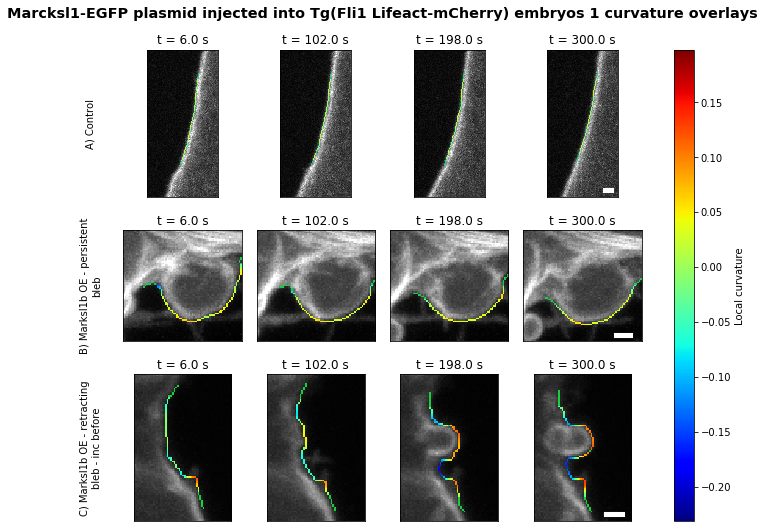

In [6]:
#experiment_folder = "D:\\data\\Inverse blebbing\\Experiment 1";
experiment_folder = "D:\\analysis\\2018-12-28 Images for LKP presentation\\Marcksl1-EGFP plasmid injected into Tg(Fli1 Lifeact-mCherry) embryos 1";
chosen_timepoints = [6, 100, 200, 300];
condition_names = None;
#condition_names = ["control", "condition 1", "condition 2"];
scale_bar_size_um = 1.0;
scale_bar_position = (0.75, 0.9) # in normalised axis coordinates
scale_bar_color = 'w';
use_subfolder_as_condition = True;

ims = [];
raw_curvatures = [];
paramses = [];
subtitles = [];
# load and plot images
experiment_title = os.path.basename(experiment_folder);
for idx, subfolder in enumerate(os.listdir(experiment_folder)):
    ims.append(io.imread(os.path.join(experiment_folder, subfolder, "overlaid curvature.tif")));
    raw_curvatures.append(io.imread(os.path.join(experiment_folder, subfolder, "raw curvature.tif")));
    params = Parameters();
    params.loadParametersFromJson(os.path.join(experiment_folder, subfolder, "parameters used.json"));
    paramses.append(params);
    if condition_names is None:
        if use_subfolder_as_condition:
            subtitles.append(subfolder)
        else:
            subtitles.append(os.path.splitext(os.path.basename(params.input_image_path))[0]);
    else:
        subtitles.append(condition_names[idx]);

curv_lims =  (min([raw_cs.min() for raw_cs in raw_curvatures]), max([raw_cs.max() for raw_cs in raw_curvatures]))
fig, axs = plt.subplots(ncols=len(chosen_timepoints), nrows=len(ims), figsize=(3*len(ims),2.5*len(ims)));
for imidx in range(len(ims)):
    t_offs = 0;
    if paramses[imidx].time_crop_start_end is not None:
        t_offs = float(paramses[imidx].time_crop_start_end[0]) * paramses[imidx].frame_interval;
    chosen_frames = [round((t - t_offs)/ paramses[imidx].frame_interval) for t in chosen_timepoints];
    closest_timepoints = [fr * paramses[imidx].frame_interval + t_offs for fr in chosen_frames];
    chosen_frames = [ch if ((ch < ims[imidx].shape[0]) and (ch >= 0)) else float('nan') for ch in chosen_frames];
    for fridx, fr in enumerate(chosen_frames):
        cbw = math.ceil(0.95 * ims[imidx][0].shape[1]);
        if not math.isnan(fr):
            curv_pix = np.nonzero(raw_curvatures[imidx][fr]);
            for pixx, pixy in zip(curv_pix[0], curv_pix[1]):
                curv = raw_curvatures[imidx][fr][pixx][pixy];
                existing_val = ims[imidx][fr][pixx][pixy];
                curv_idx_8bit = int(round(255 * (curv - curv_lims[0]) / (curv_lims[1] - curv_lims[0])));
                r, g, b, _ = cm.jet(curv_idx_8bit);
                ims[imidx][fr][pixx][pixy][0] = int(round(255*r));
                ims[imidx][fr][pixx][pixy][1] = int(round(255*g));
                ims[imidx][fr][pixx][pixy][2] = int(round(255*b));
            axs[imidx][fridx].imshow(ims[imidx][fr][:, :cbw, :]);
            axs[imidx][fridx].set_title("t = " + str(closest_timepoints[fridx]) + " s");
        else:
            axs[imidx][fridx].imshow(ims[imidx][0][:, :cbw, :], alpha=0);
            axs[imidx][fridx].set_frame_on(False);
            axs[imidx][fridx].set_visible(False);
        axs[imidx][fridx].set_xticks([]);
        axs[imidx][fridx].set_yticks([]);
        #if fridx == 0:
        #    axs[imidx][fridx].set_ylabel("\n".join(wrap(subtitles[imidx], 30)));
        if fridx == chosen_frames.index(max([f for f in chosen_frames if not np.isnan(f)])):
            add_scalebar(paramses[imidx], 
                         axs[imidx][fridx], 
                         fig, 
                         color=scale_bar_color, 
                         scale_bar_size_um=scale_bar_size_um);
            sb_ydata=[0.95 * ims[imidx][0].shape[0], 0.95 * ims[imidx][0].shape[0]]; 

plt.tight_layout();
fig.subplots_adjust(top=0.9, right=0.9, hspace=0.1, left=0.1);
cmap = plt.get_cmap('jet');
norm = colors.Normalize(vmin=curv_lims[0],vmax=curv_lims[1]);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm);
sm.set_array([]);
cbar_ax1 = fig.add_axes([0.95, axs[len(ims)-1][len(chosen_timepoints)-1].get_position().y0, 0.03, (axs[0][len(chosen_timepoints)-1].get_position().y1 - axs[len(ims)-1][len(chosen_timepoints)-1].get_position().y0)])
fig.colorbar(sm, cax=cbar_ax1);
cbar_ax1.set_ylabel("Local curvature");
plt.rc('figure', titlesize='x-large', titleweight='bold');
fig.suptitle(experiment_title + " curvature overlays");
for imidx in range(len(ims)):
    bbox = axs[imidx][0].get_position();
    txt = Text(0.05, 0.5*(bbox.ymin + bbox.ymax), "\n".join(wrap(subtitles[imidx], 30)), rotation='vertical', horizontalalignment='center', va='center');
    fig.add_artist(txt)

In [13]:
with open("D:\\analysis\\2018-12-28 Images for LKP presentation\\Marcksl1-EGFP plasmid injected into Tg(Fli1 Lifeact-mCherry) embryos 2\\C) Marksl1b OE - retracting bleb\\bleb area.csv") as f:
    print(f)

<_io.TextIOWrapper name='D:\\analysis\\2018-12-28 Images for LKP presentation\\Marcksl1-EGFP plasmid injected into Tg(Fli1 Lifeact-mCherry) embryos 2\\C) Marksl1b OE - retracting bleb\\bleb area.csv' mode='r' encoding='cp1252'>
